<a href="https://www.kaggle.com/code/keremkosif/car-detection-fasterrcnn-detectron2?scriptVersionId=97118979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook: Object Detection - FasterRCNN - Detectron2

    This project goes trough a FasterRCNN implementation for detecting cars and pedestrians from a drone footage. To correctly classify desired objects, Facebooks Detectron2 did an amazing job to make programmers implement complicated computer vision algorithms easily. For original Detectron2 github repo, you can visit: https://github.com/facebookresearch/detectron2

# Lets Begin!
    
    Object detection is getting more and more popular over the years. With so many applications of object detection like: Face detection, object detection, keypoint detection etc... Air devices like helicopters and quadcopters may need an object detector to detect humans and cars along their way. So in this project car and human detection will be center of the project.

# Dataset
    As for dataset, I widely search the internet and found a good video inlcuding desired objects to detect. So I splited the video to its frames. Then uploaded my frames to roboflow to annote and preprocces. After getting the annotions I translated them into detectron2's desired format. 

**Datafiles:**
* **d2-deneme-train.json**: This file contains all annotions of the training image dataset.
* **d2-deneme-valid.json**: This file contains all annotions of the validation image dataset.
* **All images files**.

**Installing the Detectron2**

In [1]:
pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-req-build-0xzvb27z
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0xzvb27z
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
     |████████████████████████████████| 106 kB 944 kB/s 
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
    Preparing wheel metadata ... - \ | / - done
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 151 kB 5.8 MB/s 
     |████████████████████████████████| 130 kB 11.7 MB/s 
     |████████████████████████████████| 117 kB 12.9 MB/s 
  Created wheel for detectron2: filename=detectron2-0.5-cp37-cp37m-linux_x86_64.whl size=5183506 sha256=7a2bbd16aeeaeed394271c6aa9eba8ec26d4a9bb2da9760ecd1d67b120351744

**Import the libraries**

In [2]:
import os
import json
import random
import cv2
from matplotlib import pyplot as plt
import numpy as np

from detectron2.structures import BoxMode
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are

In [3]:
def load_json_labels(image_folder):
    # Get absolute path of JSON label file
    for file in os.listdir(image_folder):
        if file.endswith(".json"):
            json_file = os.path.join(image_folder, file)

    # Check to see if json_file exists 
    assert json_file, "No .json label file found, please make one with get_image_dicts()"

    with open(json_file, "r") as f:
        img_dicts = json.load(f)

    # Convert bbox_mode to Enum of BoxMode.XYXY_ABS (doesn't work loading normal from JSON)
    for img_dict in img_dicts:
        for annot in img_dict["annotations"]:
            annot["bbox_mode"] = BoxMode.XYXY_ABS

    return img_dicts

# Step 1: Register Dataset To Detectron2
    Having the annotion files and images is not enought for detectron2. Inorder to use annotions json files must be registered to the DatasetCatalog object along with the images.

In [4]:
# Register datasets with Detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog

for dataset in ["train", "valid"]:
    
    # Create dataset name strings
    dataset_name = "d2-deneme-" + dataset
    print(f"Registering {dataset_name}")

    # Register the datasets with Detectron2's DatasetCatalog, which has space for a lambda function to preprocess it
    DatasetCatalog.register(dataset_name, lambda dataset_name=dataset_name: load_json_labels("../input/d2deneme/" + dataset_name))

    # Create the metadata for our dataset (the main thing being the classnames we're using)
    MetadataCatalog.get(dataset_name).set(thing_classes=["yaya", "arac", "UAP-1", "UAP-0", "UAI-1", "UAI-0"])

# Setup metadata variable
cmaker_fireplace_metadata = MetadataCatalog.get("d2-deneme-train")

Registering d2-deneme-train
Registering d2-deneme-valid


**Open and transform json annotion files.**

In [5]:
with open("../input/d2deneme/d2-deneme-train/d2-deneme-train.json", "r") as jsonn:
    train_img_dicts = json.load(jsonn)
    train_img_dicts = train_img_dicts
    
with open("../input/d2deneme/d2-deneme-valid/d2-deneme-valid.json", "r") as jsonn:
    val_img_dicts = json.load(jsonn)
    val_img_dicts = val_img_dicts

**Select random three pictures from dataset and display them**

../input/d2deneme/d2-deneme-train/frame2804_jpg.rf.02fe309f62779a4bfd531edbfefd4681.jpg


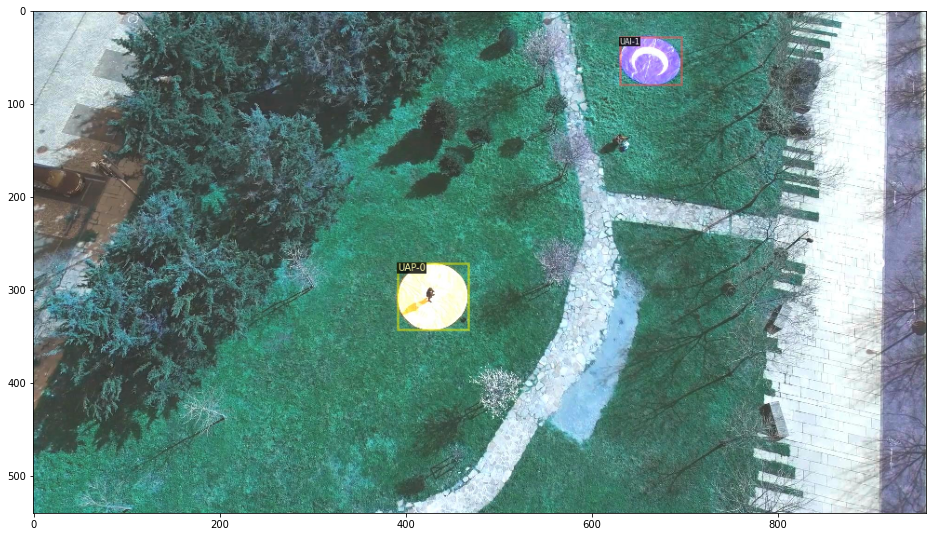

../input/d2deneme/d2-deneme-train/frame4592_jpg.rf.52dbad9dadc6eb0a86cfa19545143c43.jpg


../input/d2deneme/d2-deneme-train/frame3736_jpg.rf.d4a0c85182951e3a29f463df273d2f1c.jpg


In [6]:
%matplotlib inline
for label in random.sample(train_img_dicts, 3):
    plt.figure(figsize=(16,10)) # to set the figure size
    print(label["file_name"])
    img = cv2.imread(label["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], # revervse the image pixel order (BGR -> RGB)
                            metadata=cmaker_fireplace_metadata, # use the metadata variable we created about
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(label)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Step 2: Configure The Cfg File

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# Setup a model config (recipe for training a Detectron2 model)
cfg=get_cfg()

# Add some basic instructions for the Detectron2 model from the model_zoo: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0]]
# [[0.25, 0.5, 1.0, 2.0, 4.0, 8.0]]

cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p3', 'p4', 'p5', 'p6']
cfg.INPUT.MIN_SIZE_TRAIN = 0
cfg.INPUT.MAX_SIZE_TRAIN = 99999
cfg.INPUT.RANDOM_FLIP = "horizontal"

# Setup datasets to train/validate on (this will only work if the datasets are registered with DatasetCatalog)
cfg.DATASETS.TRAIN = ("d2-deneme-train",)
cfg.DATASETS.TEST = ("d2-deneme-valid",)

# How many dataloaders to use? This is the number of CPUs to load the data into Detectron2, Colab has 2, so we'll use 2
cfg.DATALOADER.NUM_WORKERS = 2

# How many images per batch? The original models were trained on 8 GPUs with 16 images per batch, since we have 1 GPU: 16/8 = 2.
cfg.SOLVER.IMS_PER_BATCH = 2

# We do the same calculation with the learning rate as the GPUs, the original model used 0.01, so we'll divide by 8: 0.01/8 = 0.00125.
cfg.SOLVER.BASE_LR = 0.00125

# How many iterations are we going for? (300 is okay for our small model, increase for larger datasets)
cfg.SOLVER.MAX_ITER = 1000

# ROI = region of interest, as in, how many parts of an image are interesting, how many of these are we going to find? 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.RETINANET.NUM_CLASSES = 6

# Setup output directory, all the model artefacts will get stored here in a folder called "outputs" 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Setup the default Detectron2 trainer, see: https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultTrainer
trainer = DefaultTrainer(cfg)

# Resume training from model checkpoint or not, we're going to just load the model in the config: https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultTrainer.resume_or_load
trainer.resume_or_load(resume=False)

# Start training
trainer.train()

model_final_f6e8b1.pkl: 243MB [00:03, 62.2MB/s]                           
/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


# Step3: Create Enviroment For Testing

In [8]:
# Get the final model weights from the outputs directory
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

# Set the testing threshold (a value between 0 and 1, higher makes it more difficult for a prediction to be made)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.INPUT.MIN_SIZE_TEST = 0
cfg.INPUT.MAX_SIZE_TEST = 99999

# Tell the config what the test dataset is (we've already done this)
cfg.DATASETS.TEST = ("d2-deneme-valid",) 

# Setup a default predictor from Detectron2: https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultPredictor
predictor = DefaultPredictor(cfg)

**Can be used If brightness needed to be adjust.**

In [9]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# Step 4: Observe Results!

../input/d2deneme/d2-deneme-valid/frame2824_jpg.rf.be3d47087f0fb9f35a077ed3f72d9db7.jpg
../input/d2deneme/d2-deneme-valid/frame2740_jpg.rf.7d5c1e89803895394ba8653026542971.jpg
../input/d2deneme/d2-deneme-valid/frame2612_jpg.rf.3a0af41d8df9b1ac48c8438e5af18804.jpg


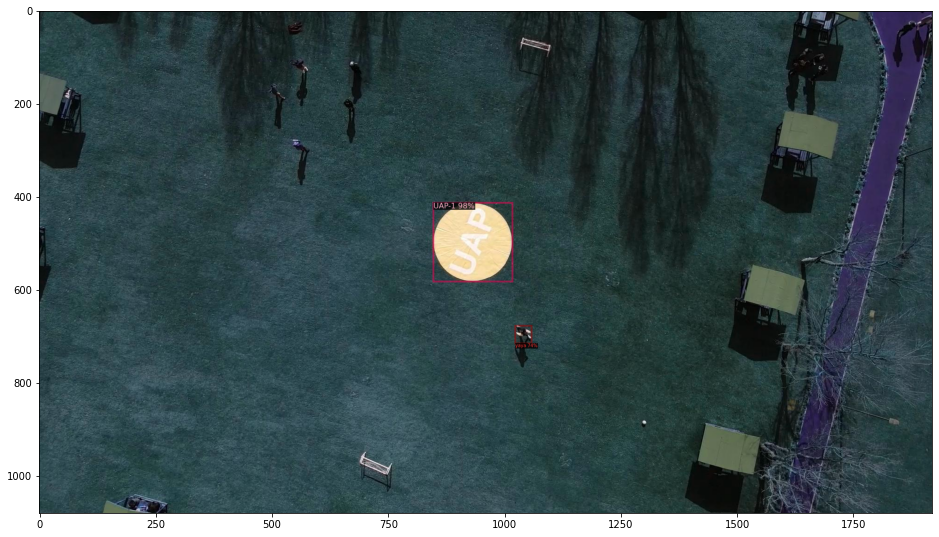

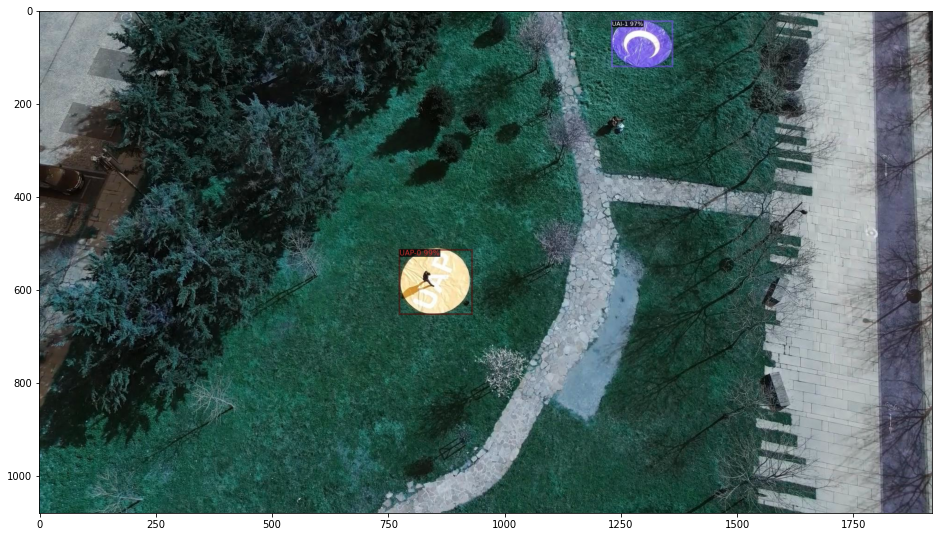

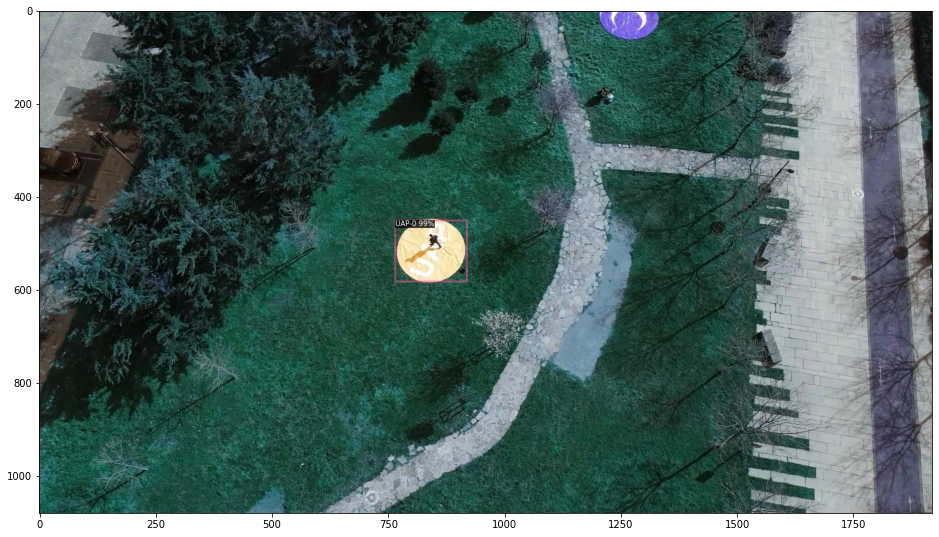

In [10]:
%matplotlib inline
#num_amenities = 5 # how many amenity detections to draw on the image
for label in random.sample(val_img_dicts, 3): # select random samples from the validation set
    plt.figure(figsize=(16,10)) # to set the figure size
    print(label["file_name"])
    img = cv2.imread(label["file_name"])
    #img = change_brightness(img, value=30)
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1],
                          metadata=cmaker_fireplace_metadata,
                          scale=1)
    visualizer = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(visualizer.get_image()[:, :, ::-1])

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(dataset_name="d2-deneme-valid", distributed=False,output_dir="./output")
val_loader = build_detection_test_loader(cfg, dataset_name="d2-deneme-valid")
inference_on_dataset(model=trainer.model, data_loader=val_loader, evaluator=evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.786
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 81.50434671796812,
               'AP50': 93.31735249296256,
               'AP75': 88.68932798452259,
               'APs': 25.917310412359917,
               'APm': 37.69392460742122,
               'APl': 90.99815478115318,
               'AP-yaya': 34.035306402042856,
               'AP-arac': 84.99077390576586,
               'AP-UAP-1': 90.0,
               'AP-UAP-0': 90.0,
               'AP-UAI-1': 90.0,
               'AP-UAI-0': 100.0})])